TODO:
- pipeline
    - missing raw pitch type?
- features
    - last pitch ball? 2nd to last pitch ball?
    - inning pitch count (especially first pitch of inning)
- architecture
    - normalization?
    - dropout?
    - keras tuner?
- modeling
    - look into typical ABs
    - look into "other"
- inference
    - plot SHAP values (/equivalent)

Inferences
- Very highly confident pitches are when:
    - 3 and 0 (or to a lesser degree behind in the count)
    - all pitches in the at bat have been of the same type (or sometimes all but 1)
- 

In [387]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, Activation
from tensorflow.data import Dataset
import keras_tuner
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
pd.set_option("display.max_columns", 100)


In [388]:
season = 2022
season_df = pd.read_csv(f"data/{season}.csv")
season_df.tail()


,game_id,inning,top,at_bat_index,home_score,away_score,outs,pitcher_name,pitcher_id,pitcher_lefty,batter_name,batter_id,batter_lefty,runner_1,runner_2,runner_3,balls,strikes,pitch_type,at_bat,raw_pitch_type,count,pitch_type_lag_1,pitch_type_lag_2,lag_1_ball,lag_1_strike,lag_2_ball,lag_2_strike,lag_3_ball,lag_3_strike,pitch_count,inning_pitch_count,ab_pitch_count,ab_changeup_count,ab_curveball_count,ab_cutter_count,ab_fastball_count,ab_knuckle_curve_count,ab_other_count,ab_sinker_count,ab_slider_count,ab_splitter_count,nth_season_pitch,fastball_rate,curveball_rate,changeup_rate,slider_rate,sinker_rate,cutter_rate,knuckle_curve_rate,splitter_rate,other_rate
708168,663463,9,False,77,2,7,1,Cody Stashak,664054,False,Jorge Mateo,622761,False,False,False,False,0,0,slider,77,Slider,"(0,0)",none,none,False,False,False,False,False,False,6,6,0,0,0,0,0,0,0,0,0,0,223,0.488789,0.0,0.017937,0.493274,0.0,0.0,0.0,0.0,0.0
708169,663463,9,False,77,2,7,1,Cody Stashak,664054,False,Jorge Mateo,622761,False,False,False,False,1,0,slider,77,Slider,"(1,0)",slider,none,True,False,False,False,False,False,7,7,1,0,0,0,0,0,0,0,1,0,224,0.486607,0.0,0.017857,0.495536,0.0,0.0,0.0,0.0,0.0
708170,663463,9,False,77,2,7,1,Cody Stashak,664054,False,Jorge Mateo,622761,False,False,False,False,1,1,slider,77,Slider,"(1,1)",slider,slider,False,True,True,True,False,False,8,8,2,0,0,0,0,0,0,0,2,0,225,0.484444,0.0,0.017778,0.497778,0.0,0.0,0.0,0.0,0.0
708171,663463,9,False,78,2,7,2,Cody Stashak,664054,False,Cedric Mullins,656775,True,False,False,False,0,0,fastball,78,Four-Seam Fastball,"(0,0)",none,none,False,False,False,False,False,False,9,9,0,0,0,0,0,0,0,0,0,0,226,0.486726,0.0,0.017699,0.495575,0.0,0.0,0.0,0.0,0.0
708172,663463,9,False,78,2,7,2,Cody Stashak,664054,False,Cedric Mullins,656775,True,False,False,False,0,1,fastball,78,Four-Seam Fastball,"(0,1)",fastball,none,False,True,False,False,False,False,10,10,1,0,0,0,1,0,0,0,0,0,227,0.488987,0.0,0.017621,0.493392,0.0,0.0,0.0,0.0,0.0


In [389]:
df = season_df.copy(deep=True)
dummy_df = pd.get_dummies(df[['count', 'pitch_type_lag_1', 'pitch_type_lag_2']], prefix=['count', 'lag_1', 'lag_2'])
df = df.join(dummy_df)
df.head()


,game_id,inning,top,at_bat_index,home_score,away_score,outs,pitcher_name,pitcher_id,pitcher_lefty,batter_name,batter_id,batter_lefty,runner_1,runner_2,runner_3,balls,strikes,pitch_type,at_bat,raw_pitch_type,count,pitch_type_lag_1,pitch_type_lag_2,lag_1_ball,lag_1_strike,lag_2_ball,lag_2_strike,lag_3_ball,lag_3_strike,pitch_count,inning_pitch_count,ab_pitch_count,ab_changeup_count,ab_curveball_count,ab_cutter_count,ab_fastball_count,ab_knuckle_curve_count,ab_other_count,ab_sinker_count,ab_slider_count,ab_splitter_count,nth_season_pitch,fastball_rate,curveball_rate,changeup_rate,slider_rate,sinker_rate,cutter_rate,knuckle_curve_rate,splitter_rate,other_rate,"count_(0,0)","count_(0,1)","count_(0,2)","count_(1,0)","count_(1,1)","count_(1,2)","count_(2,0)","count_(2,1)","count_(2,2)","count_(3,0)","count_(3,1)","count_(3,2)",lag_1_changeup,lag_1_curveball,lag_1_cutter,lag_1_fastball,lag_1_knuckle_curve,lag_1_none,lag_1_other,lag_1_sinker,lag_1_slider,lag_1_splitter,lag_2_changeup,lag_2_curveball,lag_2_cutter,lag_2_fastball,lag_2_knuckle_curve,lag_2_none,lag_2_other,lag_2_sinker,lag_2_slider,lag_2_splitter
0,661032,1,True,0,0,0,0,Patrick Sandoval,663776,True,Myles Straw,664702,False,False,False,False,0,0,fastball,0,Four-Seam Fastball,"(0,0)",none,none,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,661032,1,True,0,0,0,0,Patrick Sandoval,663776,True,Myles Straw,664702,False,False,False,False,1,0,fastball,0,Four-Seam Fastball,"(1,0)",fastball,none,True,False,False,False,False,False,1,1,1,0,0,0,1,0,0,0,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,661032,1,True,0,0,0,0,Patrick Sandoval,663776,True,Myles Straw,664702,False,False,False,False,1,1,curveball,0,Curveball,"(1,1)",fastball,fastball,False,True,True,True,False,False,2,2,2,0,0,0,2,0,0,0,0,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,661032,1,True,0,0,0,0,Patrick Sandoval,663776,True,Myles Straw,664702,False,False,False,False,1,2,changeup,0,Changeup,"(1,2)",curveball,fastball,False,True,False,True,True,True,3,3,3,0,1,0,2,0,0,0,0,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,661032,1,True,1,0,0,1,Patrick Sandoval,663776,True,Amed Rosario,642708,False,False,False,False,0,0,fastball,1,Four-Seam Fastball,"(0,0)",none,none,False,False,False,False,False,False,4,4,0,0,0,0,0,0,0,0,0,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [440]:
pitch_types = list(df.pitch_type.unique())
direct_features = ['inning', 'top', 'outs', 'pitch_count', 'inning_pitch_count', 'ab_pitch_count', 'pitcher_lefty', 'batter_lefty']
direct_features.extend(['lag_1_ball', 'lag_1_strike'])#, 'lag_2_ball', 'lag_2_strike'])#, 'lag_3_ball', 'lag_3_strike']) 
direct_features.extend(['runner_1', 'runner_2', 'runner_3'])
direct_features.extend([f"ab_{pitch_type}_count" for pitch_type in pitch_types])
features = direct_features + list(dummy_df.columns) + [c for c in df.columns if c.endswith("_rate")]
X = df.loc[df['raw_pitch_type'] != "Automatic Ball"].dropna(subset=features)[features]
y = df.loc[df['raw_pitch_type'] != "Automatic Ball"].dropna(subset=features)['pitch_type']
y = pd.get_dummies(y)
X.head()



,inning,top,outs,pitch_count,inning_pitch_count,ab_pitch_count,pitcher_lefty,batter_lefty,lag_1_ball,lag_1_strike,runner_1,runner_2,runner_3,ab_fastball_count,ab_curveball_count,ab_changeup_count,ab_slider_count,ab_sinker_count,ab_cutter_count,ab_knuckle_curve_count,ab_splitter_count,ab_other_count,"count_(0,0)","count_(0,1)","count_(0,2)","count_(1,0)","count_(1,1)","count_(1,2)","count_(2,0)","count_(2,1)","count_(2,2)","count_(3,0)","count_(3,1)","count_(3,2)",lag_1_changeup,lag_1_curveball,lag_1_cutter,lag_1_fastball,lag_1_knuckle_curve,lag_1_none,lag_1_other,lag_1_sinker,lag_1_slider,lag_1_splitter,lag_2_changeup,lag_2_curveball,lag_2_cutter,lag_2_fastball,lag_2_knuckle_curve,lag_2_none,lag_2_other,lag_2_sinker,lag_2_slider,lag_2_splitter,fastball_rate,curveball_rate,changeup_rate,slider_rate,sinker_rate,cutter_rate,knuckle_curve_rate,splitter_rate,other_rate
762,7,False,1,99,11,5,False,False,True,False,False,True,False,1,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.350000,0.0,0.010000,0.460000,0.000000,0.020000,0.16,0.0,0.0
1100,1,True,1,6,6,2,False,True,False,True,False,False,False,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.140000,0.0,0.150000,0.260000,0.350000,0.100000,0.00,0.0,0.0
1101,1,True,2,7,7,0,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.148515,0.0,0.148515,0.257426,0.346535,0.099010,0.00,0.0,0.0
1102,1,True,2,8,8,1,False,False,False,True,False,False,False,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.147059,0.0,0.147059,0.254902,0.352941,0.098039,0.00,0.0,0.0
1103,1,True,2,9,9,2,False,False,True,False,False,False,False,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0.145631,0.0,0.145631,0.262136,0.349515,0.097087,0.00,0.0,0.0


In [441]:
ss = StandardScaler()
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=123)
X_train_numpy = X_train.astype(float).to_numpy()
y_train_numpy = y_train.astype(float).to_numpy()
X_val_numpy = X_val.astype(float).to_numpy()
y_val_numpy = y_val.astype(float).to_numpy()
X_train_numpy = ss.fit_transform(X_train_numpy)
X_val_numpy = ss.transform(X_val_numpy)
input_shape = X.shape[1]
output_shape = y.shape[1]


____

#### Tuner

In [442]:
# class CustomHyperModel(keras_tuner.HyperModel):
#     def __init__(self, input_shape, output_shape):
#         self.input_shape = input_shape
#         self.output_shape = output_shape
        
#     def build(self, hp):
#         ann = keras.Sequential(name='sequential_ann')
#         ann.add(keras.Input(shape=(self.input_shape,)))
#         ann.add(
#             layers.Dense(
#                 units=hp.Int("units", min_value=32, max_value=64, step=32),
#                 activation="relu"
#             )
#         )
#         ann.add(layers.Dense(64, activation='relu'))
#         ann.add(layers.Dense(self.output_shape, activation='softmax'))
#         ann.compile(loss='categorical_crossentropy', metrics=['accuracy'])
#         return ann


In [443]:
# tuner = keras_tuner.RandomSearch(
#     hypermodel=CustomHyperModel(input_shape, output_shape),
#     objective='val_accuracy',
#     max_trials=3,
#     overwrite=True
# )
# tuner.search(X_train_numpy, y_train_numpy, epochs=2, validation_data=(X_val_numpy, y_val_numpy))

In [444]:
# model = tuner.get_best_models()[0]
# model.summary()


____

In [445]:
print("TODO: tune normalization")
print("TODO: add dropout?")
ann = keras.Sequential(name='sequential_ann')
ann.add(keras.Input(shape=(input_shape,)))
# Hidden Layer 1
ann.add(layers.Dense(32, name='dense1'))
# ann.add(layers.Normalization())
ann.add(layers.Activation('relu'))
# ann.add(layers.Dropout(0.2))
# Hidden Layer 2
ann.add(layers.Dense(32, name='dense2'))
# ann.add(layers.Normalization())
ann.add(layers.Activation('relu'))
# ann.add(layers.Dropout(0.2))
# Output Layer
ann.add(layers.Dense(output_shape, name="softmax"))
ann.add(layers.Activation("softmax"))
ann.summary()


TODO: tune normalization
TODO: add dropout?
Model: "sequential_ann"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense1 (Dense)              (None, 32)                2048      
                                                                 
 activation_30 (Activation)  (None, 32)                0         
                                                                 
 dense2 (Dense)              (None, 32)                1056      
                                                                 
 activation_31 (Activation)  (None, 32)                0         
                                                                 
 softmax (Dense)             (None, 9)                 297       
                                                                 
 activation_32 (Activation)  (None, 9)                 0         
                                                                 
Total pa

In [446]:
lr = 5e-4
patience = 3
batch_size = 64
epochs = 50

opt = keras.optimizers.Adam(learning_rate=lr)
ann.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
history = ann.fit(
    X_train_numpy,
    y_train_numpy,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_numpy, y_val_numpy),
    callbacks=[callback],
    verbose=2
)

Epoch 1/50
7374/7374 - 5s - loss: 1.2622 - acc: 0.4588 - val_loss: 1.1872 - val_acc: 0.4726 - 5s/epoch - 731us/step
Epoch 2/50
7374/7374 - 5s - loss: 1.1749 - acc: 0.4755 - val_loss: 1.1646 - val_acc: 0.4772 - 5s/epoch - 727us/step
Epoch 3/50
7374/7374 - 5s - loss: 1.1584 - acc: 0.4792 - val_loss: 1.1564 - val_acc: 0.4777 - 5s/epoch - 682us/step
Epoch 4/50
7374/7374 - 5s - loss: 1.1512 - acc: 0.4814 - val_loss: 1.1525 - val_acc: 0.4772 - 5s/epoch - 684us/step
Epoch 5/50
7374/7374 - 5s - loss: 1.1469 - acc: 0.4830 - val_loss: 1.1483 - val_acc: 0.4805 - 5s/epoch - 679us/step
Epoch 6/50
7374/7374 - 5s - loss: 1.1441 - acc: 0.4840 - val_loss: 1.1485 - val_acc: 0.4805 - 5s/epoch - 684us/step
Epoch 7/50
7374/7374 - 5s - loss: 1.1417 - acc: 0.4851 - val_loss: 1.1435 - val_acc: 0.4822 - 5s/epoch - 686us/step
Epoch 8/50
7374/7374 - 5s - loss: 1.1399 - acc: 0.4855 - val_loss: 1.1423 - val_acc: 0.4834 - 5s/epoch - 688us/step
Epoch 9/50
7374/7374 - 8s - loss: 1.1384 - acc: 0.4865 - val_loss: 1.143

In [447]:
y_hat = ann.predict(X_val_numpy)
y_hat = pd.DataFrame(y_hat, index=y_val.index, columns=y_val.columns)


4916/4916 [==============================] - 2s 390us/step


In [427]:
y_eval = y_hat.copy(deep=True)
y_eval['observed'] = y_val.idxmax(axis=1)
g = y_eval.groupby('observed').mean().reset_index()
g.sort_values('observed', key=lambda x: x.map(y_train.sum()), inplace=True, ascending=False)
g = g[['observed'] + list(y_train.sum().sort_values(ascending=False).index)].copy(deep=True) # reorder columns
g.reset_index(drop=True, inplace=True)
g


,observed,fastball,slider,sinker,changeup,curveball,cutter,knuckle_curve,splitter,other
0,fastball,0.442030,0.206187,0.073072,0.109888,0.085104,0.049151,0.020916,0.013402,0.000249
1,slider,0.293880,0.388147,0.145455,0.071964,0.049198,0.029927,0.013227,0.008035,0.000168
2,sinker,0.136703,0.192745,0.418875,0.093455,0.070720,0.064711,0.014030,0.008369,0.000391
3,changeup,0.284353,0.127263,0.138290,0.283893,0.088966,0.062714,0.013754,0.000541,0.000227
4,curveball,0.288520,0.113649,0.132535,0.122909,0.257537,0.077716,0.000010,0.006562,0.000562
5,cutter,0.208729,0.091286,0.157022,0.100135,0.088909,0.324244,0.019100,0.010126,0.000450
6,knuckle_curve,0.296175,0.138394,0.117221,0.074447,0.000068,0.069386,0.292201,0.010812,0.001295
7,splitter,0.340743,0.128524,0.111419,0.004195,0.046027,0.058907,0.019288,0.290786,0.000111
8,other,0.114534,0.080030,0.077267,0.034762,0.065815,0.052859,0.039496,0.000666,0.534571


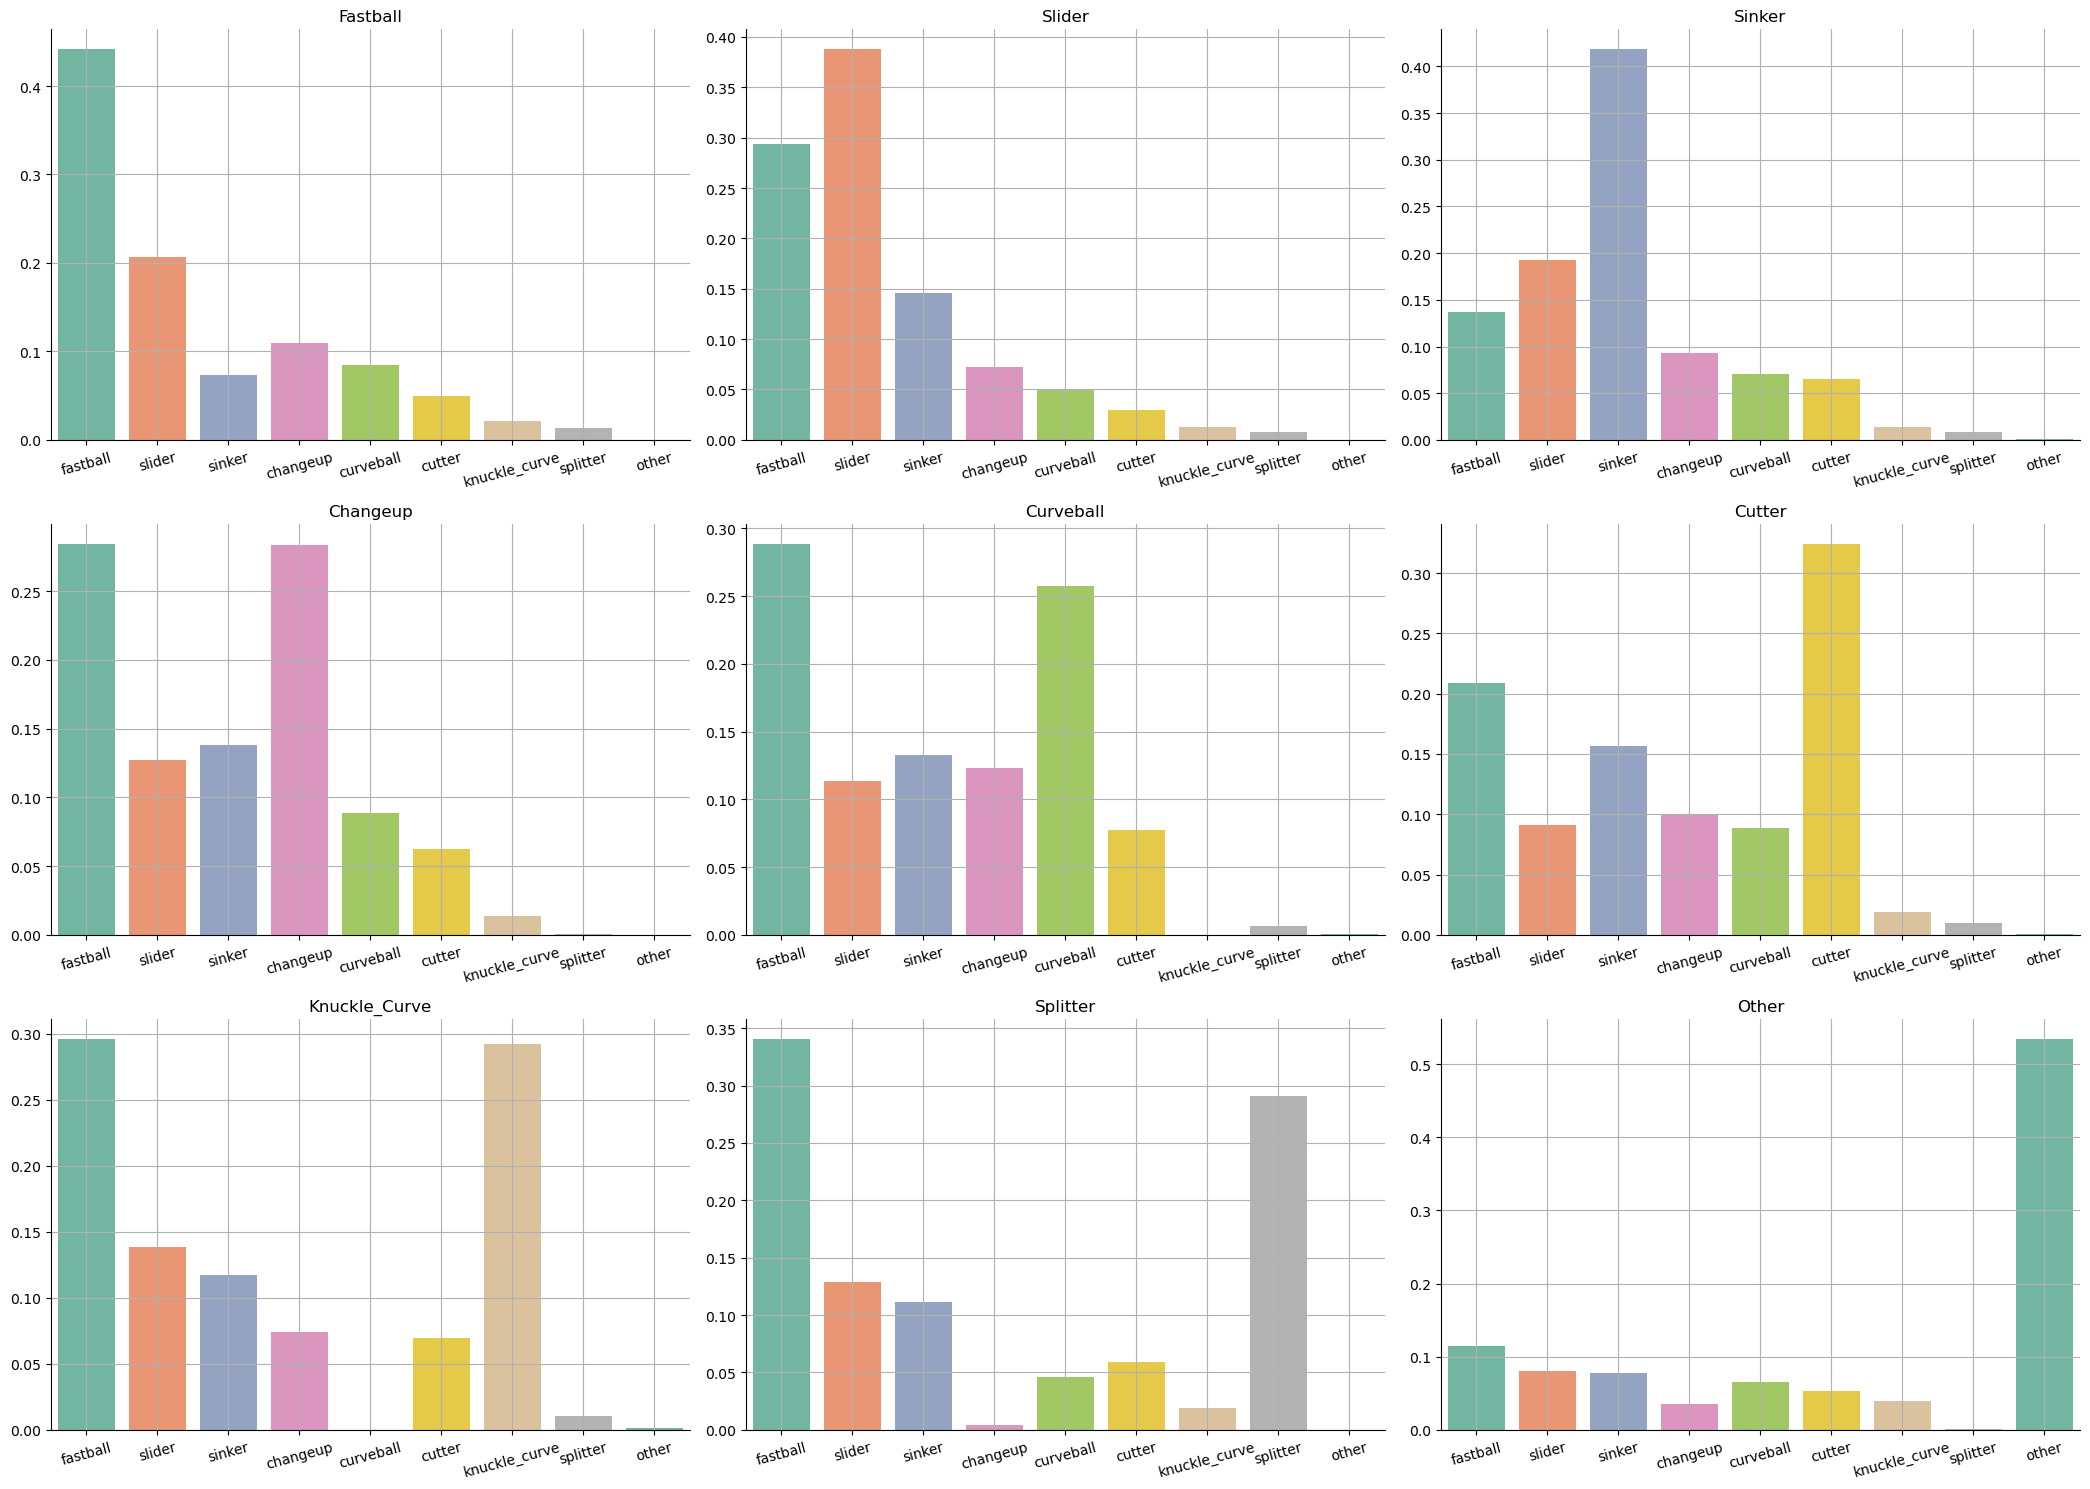

In [428]:
fig, axes = plt.subplots(3, 3, figsize=(21, 15))
for i, ax in enumerate(axes.ravel()):
    probabilities = g.iloc[i]
    observed = probabilities.pop('observed')
    sns.barplot(x=probabilities.index, y=probabilities.values, ax=ax, palette='Set2')
    ax.set(title=observed.title())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
    ax.grid()
    
plt.tight_layout()
sns.despine()

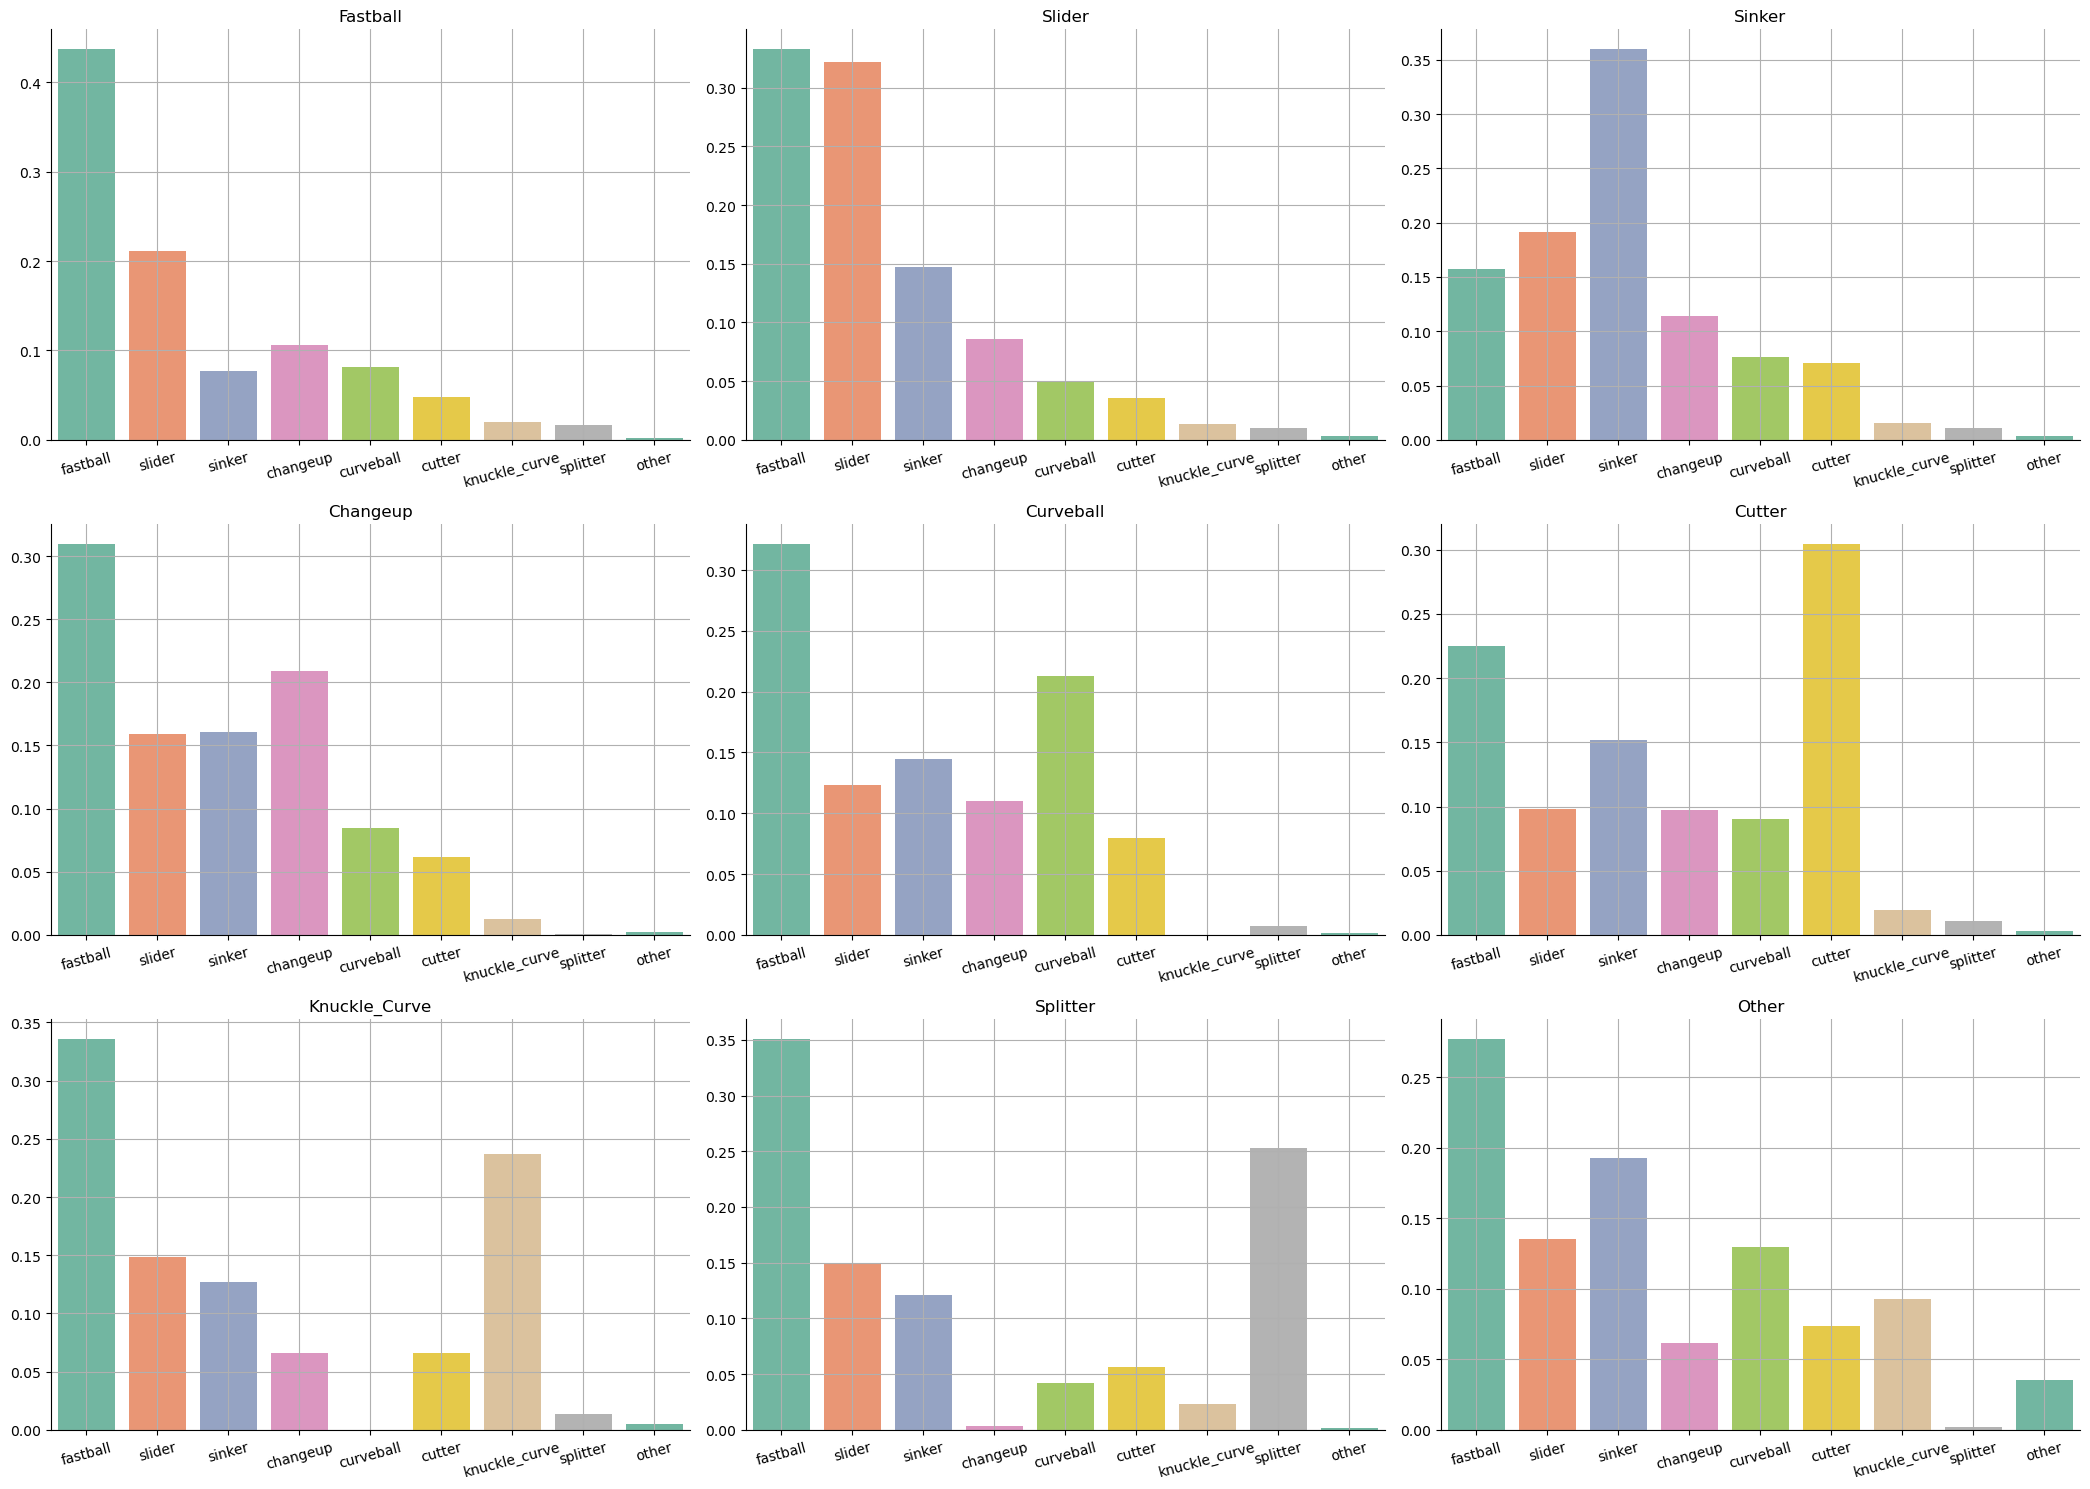

In [429]:
X_eval = X_val.copy(deep=True)
X_eval['pitch_type'] = y_val.idxmax(axis=1)
pitch_rates = [c for c in X_eval.columns if c.endswith("_rate")]
mean_rate_by_type = X_eval.groupby('pitch_type')[pitch_rates].mean()
mean_rate_by_type.sort_index(key=lambda x: x.map(y_train.sum()), inplace=True, ascending=False)
mean_rate_by_type = mean_rate_by_type[[c + "_rate" for c in list(y_train.sum().sort_values(ascending=False).index)]].copy(deep=True) 

fig, axes = plt.subplots(3, 3, figsize=(21, 15))
for i, ax in enumerate(axes.ravel()):
    pitch_type = mean_rate_by_type.index[i]
    mean_rates = mean_rate_by_type.iloc[i]
    sns.barplot(x=mean_rates.index, y=mean_rates.values, ax=ax, palette='Set2')
    ax.set(title=pitch_type.title())
    ax.set_xticklabels([x.get_text().replace("_rate", "") for x in ax.get_xticklabels()], rotation=15)
    ax.grid()
    
plt.tight_layout()
sns.despine()

In [430]:
cce = keras.losses.CategoricalCrossentropy()
cce(y_val, y_hat).numpy()


1.1346015

In [431]:
cce = keras.losses.CategoricalCrossentropy()
cce(y_val, X_eval[[c + "_rate" for c in y_val.columns]]).numpy()


1.2277603779554693

_____

In [224]:
df_eval = X_eval.join(y_eval)
df_eval.rename(columns={c: c+"_prob" for c in pitch_types}, inplace=True)
df_eval.head()


,inning,top,outs,pitch_count,ab_pitch_count,pitcher_lefty,batter_lefty,runner_1,runner_2,runner_3,ab_fastball_count,ab_curveball_count,ab_changeup_count,ab_slider_count,ab_sinker_count,ab_cutter_count,ab_knuckle_curve_count,ab_splitter_count,ab_other_count,"count_(0,0)","count_(0,1)","count_(0,2)","count_(1,0)","count_(1,1)","count_(1,2)","count_(2,0)","count_(2,1)","count_(2,2)","count_(3,0)","count_(3,1)","count_(3,2)",lag_1_changeup,lag_1_curveball,lag_1_cutter,lag_1_fastball,lag_1_knuckle_curve,lag_1_none,lag_1_other,lag_1_sinker,lag_1_slider,lag_1_splitter,lag_2_changeup,lag_2_curveball,lag_2_cutter,lag_2_fastball,lag_2_knuckle_curve,lag_2_none,lag_2_other,lag_2_sinker,lag_2_slider,lag_2_splitter,fastball_rate,curveball_rate,changeup_rate,slider_rate,sinker_rate,cutter_rate,knuckle_curve_rate,splitter_rate,other_rate,pitch_type,changeup_prob,curveball_prob,cutter_prob,fastball_prob,knuckle_curve_prob,other_prob,sinker_prob,slider_prob,splitter_prob,observed
57483,9,True,0,12,1,False,True,False,False,False,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.364734,0.094203,0.009662,0.000000,0.222222,0.309179,0.000000,0.0,0.000000,curveball,0.007155,0.128916,0.322297,0.392203,3.689262e-06,0.000118,0.148609,0.000699,4.847952e-07,curveball
408776,10,True,1,10,2,False,False,False,True,False,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0.405722,0.000000,0.217165,0.347204,0.014304,0.000000,0.000000,0.0,0.015605,slider,0.099947,0.000061,0.000047,0.387418,4.920542e-08,0.000064,0.011029,0.501435,1.444082e-09,slider
378103,8,False,0,1,1,True,True,False,False,False,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.000000,0.000000,0.000000,0.554822,0.439894,0.000000,0.000000,0.0,0.005284,sinker,0.000565,0.000256,0.000009,0.004315,1.836703e-09,0.000088,0.550392,0.444373,2.505381e-09,sinker
678518,4,False,0,55,2,False,True,False,False,False,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0.025181,0.000000,0.070849,0.364917,0.422962,0.000000,0.114383,0.0,0.001707,knuckle_curve,0.175633,0.000020,0.000015,0.005914,1.453572e-01,0.000031,0.441436,0.231586,7.335702e-06,knuckle_curve
250754,7,False,1,13,8,False,True,False,False,False,3,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.124481,0.008299,0.219917,0.340249,0.307054,0.000000,0.000000,0.0,0.000000,fastball,0.363790,0.000096,0.000081,0.396327,7.337628e-10,0.000002,0.104301,0.135403,1.645133e-12,fastball


In [226]:
df_eval['max_prob'] = df_eval[[t + "_prob" for t in pitch_types]].max(axis=1)
df_eval['max_type'] = df_eval[[t + "_prob" for t in pitch_types]].idxmax(axis=1).str.replace("_prob", "")
df_eval.loc[df_eval['observed'] != "other"].sort_values("max_prob", ascending=False).head(5)


,inning,top,outs,pitch_count,ab_pitch_count,pitcher_lefty,batter_lefty,runner_1,runner_2,runner_3,ab_fastball_count,ab_curveball_count,ab_changeup_count,ab_slider_count,ab_sinker_count,ab_cutter_count,ab_knuckle_curve_count,ab_splitter_count,ab_other_count,"count_(0,0)","count_(0,1)","count_(0,2)","count_(1,0)","count_(1,1)","count_(1,2)","count_(2,0)","count_(2,1)","count_(2,2)","count_(3,0)","count_(3,1)","count_(3,2)",lag_1_changeup,lag_1_curveball,lag_1_cutter,lag_1_fastball,lag_1_knuckle_curve,lag_1_none,lag_1_other,lag_1_sinker,lag_1_slider,lag_1_splitter,lag_2_changeup,lag_2_curveball,lag_2_cutter,lag_2_fastball,lag_2_knuckle_curve,lag_2_none,lag_2_other,lag_2_sinker,lag_2_slider,lag_2_splitter,fastball_rate,curveball_rate,changeup_rate,slider_rate,sinker_rate,cutter_rate,knuckle_curve_rate,splitter_rate,other_rate,pitch_type,changeup_prob,curveball_prob,cutter_prob,fastball_prob,knuckle_curve_prob,other_prob,sinker_prob,slider_prob,splitter_prob,observed,max_prob,max_type
683435,9,True,0,9,4,True,False,True,False,False,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.831633,0.0,0.114796,0.033163,0.0,0.000000,0.000000,0.0,0.020408,fastball,5.244544e-05,1.831667e-08,6.625463e-09,0.999791,4.328291e-10,1.015400e-10,3.430288e-06,0.000153,1.034341e-22,fastball,0.999791,fastball
662019,9,True,1,9,4,False,True,False,False,False,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.805395,0.0,0.098266,0.000000,0.0,0.013487,0.067437,0.0,0.015414,fastball,1.618301e-04,7.541335e-08,6.676195e-08,0.999699,1.057195e-04,8.457895e-10,1.459430e-05,0.000019,1.234104e-17,fastball,0.999699,fastball
656605,9,True,1,9,4,False,True,False,False,False,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.796909,0.0,0.101545,0.000000,0.0,0.015453,0.068433,0.0,0.017660,fastball,1.815615e-04,7.782880e-08,1.083791e-07,0.999665,1.181657e-04,9.649063e-10,1.595228e-05,0.000019,1.937126e-17,fastball,0.999665,fastball
478216,9,False,2,13,5,False,True,True,False,False,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.991304,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.008696,fastball,9.661417e-05,5.383666e-06,2.633886e-07,0.999447,1.678521e-09,6.289178e-09,7.108158e-07,0.000450,1.209441e-17,fastball,0.999447,fastball
336082,6,False,0,4,4,True,True,False,False,False,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.812987,0.0,0.000000,0.176623,0.0,0.000000,0.000000,0.0,0.010390,fastball,4.554488e-07,1.640754e-08,1.525498e-09,0.999379,7.412504e-12,6.099735e-11,2.335364e-06,0.000618,5.404799e-22,fastball,0.999379,fastball


In [348]:
df_eval['most_frequent_pitch'] = df_eval[[x + "_rate" for x in pitch_types]].idxmax(axis=1).str.replace("_rate", "")
confident = df_eval.loc[
    (df_eval['observed'] != "other") & 
    (df_eval['max_type'] != "other") & 
    (df_eval['count_(3,0)'] == False) &
    (df_eval['max_type'] != df_eval['most_frequent_pitch']) &
    (df_eval['max_prob'] > 0.7)
].copy(deep=True)
print(len(confident))
confident.sample(5, random_state=123)


98


,inning,top,outs,pitch_count,ab_pitch_count,pitcher_lefty,batter_lefty,runner_1,runner_2,runner_3,ab_fastball_count,ab_curveball_count,ab_changeup_count,ab_slider_count,ab_sinker_count,ab_cutter_count,ab_knuckle_curve_count,ab_splitter_count,ab_other_count,"count_(0,0)","count_(0,1)","count_(0,2)","count_(1,0)","count_(1,1)","count_(1,2)","count_(2,0)","count_(2,1)","count_(2,2)","count_(3,0)","count_(3,1)","count_(3,2)",lag_1_changeup,lag_1_curveball,lag_1_cutter,lag_1_fastball,lag_1_knuckle_curve,lag_1_none,lag_1_other,lag_1_sinker,lag_1_slider,lag_1_splitter,lag_2_changeup,lag_2_curveball,lag_2_cutter,lag_2_fastball,lag_2_knuckle_curve,lag_2_none,lag_2_other,lag_2_sinker,lag_2_slider,lag_2_splitter,fastball_rate,curveball_rate,changeup_rate,slider_rate,sinker_rate,cutter_rate,knuckle_curve_rate,splitter_rate,other_rate,pitch_type,changeup_prob,curveball_prob,cutter_prob,fastball_prob,knuckle_curve_prob,other_prob,sinker_prob,slider_prob,splitter_prob,observed,max_prob,max_type,most_frequent_pitch
322668,6,True,1,5,5,False,False,False,False,False,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.033520,0.000000,0.122905,0.458101,0.385475,0.000000,0.0,0.0,0.000000,slider,0.003068,0.000020,1.995229e-11,0.006594,3.512352e-14,7.602747e-08,0.792455,0.197862,2.449073e-17,slider,0.792455,sinker,slider
130061,7,True,1,16,5,False,False,False,False,False,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.003906,0.011719,0.000000,0.507812,0.000000,0.476562,0.0,0.0,0.000000,cutter,0.000022,0.000014,7.129802e-01,0.001849,7.322349e-12,1.362461e-05,0.000336,0.284785,6.508037e-12,cutter,0.712980,cutter,slider
319303,1,False,2,13,5,False,False,False,False,False,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.240300,0.002086,0.281602,0.219024,0.255319,0.000000,0.0,0.0,0.001669,sinker,0.033496,0.000087,4.479503e-10,0.163019,1.484469e-12,1.071467e-07,0.706098,0.097300,5.696378e-17,sinker,0.706098,sinker,changeup
384887,5,False,1,3,3,False,False,True,False,False,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.074627,0.000000,0.137042,0.404342,0.378562,0.000000,0.0,0.0,0.005427,sinker,0.008488,0.000011,3.171583e-07,0.020180,2.321104e-12,1.487234e-07,0.713633,0.257687,1.709637e-13,sinker,0.713633,sinker,slider
161638,8,True,0,5,5,False,False,False,False,False,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0.327465,0.000000,0.063380,0.278169,0.320423,0.010563,0.0,0.0,0.000000,sinker,0.000780,0.000014,1.548258e-08,0.123438,4.143764e-11,1.354924e-08,0.760453,0.115315,5.919452e-16,sinker,0.760453,sinker,fastball


In [349]:
confident.max_type.value_counts()

fastball    57
sinker      38
cutter       3
Name: max_type, dtype: int64

In [345]:
confident['max_pitches_of_type'] = confident[[f"ab_{p}_count" for p in pitch_types]].max(axis=1)
(confident['max_pitches_of_type'] + 1 == confident['ab_pitch_count']).mean()


0.46153846153846156

In [260]:
idx = 630862
df.loc[idx-1:idx+1][['inning', 'top', 'at_bat_index', 'home_score', 'away_score', 'outs', 'pitcher_name', 'batter_name', 'count', 'fastball_rate', 'sinker_rate', 'slider_rate', 'cutter_rate']]


,inning,top,at_bat_index,home_score,away_score,outs,pitcher_name,batter_name,count,fastball_rate,sinker_rate,slider_rate,cutter_rate
283700,9,True,73,5,6,1,John Brebbia,Juan Soto,"(2,0)",0.486486,0.0,0.513514,0.0
283701,9,True,73,5,6,1,John Brebbia,Juan Soto,"(3,0)",0.489933,0.0,0.510067,0.0
283702,9,True,73,5,6,1,John Brebbia,Juan Soto,"(3,1)",0.486667,0.0,0.513333,0.0
